In [2]:
import arepo
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas'

In [4]:
# sn = arepo.Snapshot(basepath + '/runs/MW2iso_fg0.5/lvl3/output', 50, combineFiles=True)
sn4 = arepo.Snapshot(basepath + '/runs/MW3iso_fg0.5/lvl4/output', 40, combineFiles=True)
sn3 = arepo.Snapshot(basepath + '/runs/MW3iso_fg0.5/lvl3/output', 40, combineFiles=True)
sn2 = arepo.Snapshot(basepath + '/runs/MW3iso_fg0.5/lvl2/output', 40, combineFiles=True)
# sn = arepo.Snapshot(basepath + '/runs/MWiso_fg0.5_Z0-newSMUGGLE/lvl3/output', 50, combineFiles=True)

In [5]:
def construct_pos_vel_mass(sn):

    ptypes = [1, 2, 3, 4]

    pos = []
    vel = []
    mass = []
    
    for pt in ptypes:
        part = getattr(sn, 'part'+str(pt))
        pos.append(part.pos.value)
        vel.append(part.vel.value)
    
        if sn.MassTable[pt] > 0:
            mass.append(np.full(sn.NumPart_Total[pt], sn.MassTable[pt].value))
        else:
            mass.append(part.mass.value)
    
    pos = np.concatenate(pos)
    vel = np.concatenate(vel)
    mass = np.concatenate(mass)
    
    return pos, vel, mass

In [6]:
pos4, vel4, mass4 = construct_pos_vel_mass(sn4)
pos3, vel3, mass3 = construct_pos_vel_mass(sn3)
pos2, vel2, mass2 = construct_pos_vel_mass(sn2)

In [7]:
tree4 = KDTree(pos4)
tree3 = KDTree(pos3)
tree2 = KDTree(pos2)

In [8]:
def get_gas_coord(sn):
    pos_gas = sn.part0.pos.value
    vel_gas = sn.part0.vel.value
    dens_gas = sn.part0.rho.value
    mass_gas = sn.part0.mass.value
    return pos_gas, vel_gas, dens_gas, mass_gas

In [9]:
pos_gas4, vel_gas4, dens_gas4, mass_gas4 = get_gas_coord(sn4)
pos_gas3, vel_gas3, dens_gas3, mass_gas3 = get_gas_coord(sn3)
pos_gas2, vel_gas2, dens_gas2, mass_gas2 = get_gas_coord(sn2)

In [11]:
r4, treekey4 = tree4.query(pos_gas4, k=64)
r3, treekey3 = tree3.query(pos_gas3, k=64)
r2, treekey2 = tree2.query(pos_gas2, k=64)

In [12]:
def avg_dens(mass, r, treekey):
    mass_in_ball = np.sum(mass[treekey], axis=1)
    volume_ball = (4*np.pi/3.) * r[:,-1]**3
    avg_dens = mass_in_ball / volume_ball
    return avg_dens

In [13]:
avg_dens4 = avg_dens(mass4, r4, treekey4)
avg_dens3 = avg_dens(mass3, r3, treekey3)
avg_dens2 = avg_dens(mass2, r2, treekey2)

In [20]:
def compute_n(sn):
    rho = np.copy(sn.part0.Density.value)
    xe  = sn.part0.ElectronAbundance
    # print(rho[rho>0])
    
    #convert rho to cgs
    UnitMass   = sn.parameters.UnitMass_in_g
    UnitLength = sn.parameters.UnitLength_in_cm
    rho *= UnitMass/UnitLength**3
    # print(UnitMass/UnitLength**3)
    
    XH = 0.76
    mp = 1.672621911E-24
    mu = 4 * mp / (1 + 3*XH + 4*XH*xe)
    
    # print(np.median(mu))
    # print(np.where(np.isnan(rho[rho>0]))[0])
    # print(rho[:10])
    
    n = rho / mu
    
    return n

In [21]:
n4 = compute_n(sn4)
n3 = compute_n(sn3)
n2 = compute_n(sn2)

In [23]:
vir4 = sn4.part0.VirialParameter
vir3 = sn3.part0.VirialParameter
vir2 = sn2.part0.VirialParameter

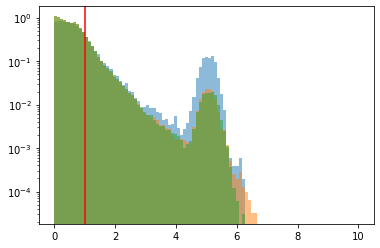

In [25]:
plt.hist(np.log10(avg_dens4/dens_gas4), density=True, alpha=0.5, bins=np.linspace(0, 10, 100));
plt.hist(np.log10(avg_dens3/dens_gas3), density=True, alpha=0.5, bins=np.linspace(0, 10, 100));
plt.hist(np.log10(avg_dens2/dens_gas2), density=True, alpha=0.5, bins=np.linspace(0, 10, 100));
plt.axvline(1, c='r')
plt.yscale('log')

In [40]:
should_be_SF4 = np.logical_and(n4 > 100, np.logical_and(vir4 > 1, (dens_gas4/(dens_gas4+avg_dens4))*vir4 < 1))
should_be_SF3 = np.logical_and(n3 > 100, np.logical_and(vir3 > 1, (dens_gas3/(dens_gas3+avg_dens3))*vir3 < 1))
should_be_SF2 = np.logical_and(n2 > 100, np.logical_and(vir2 > 1, (dens_gas2/(dens_gas2+avg_dens2))*vir2 < 1))

should_be_SF4 = np.logical_and(should_be_SF4, n4<500)
should_be_SF3 = np.logical_and(should_be_SF3, n3<500)
should_be_SF2 = np.logical_and(should_be_SF2, n2<500)

print('lvl4 should be SF', len(np.where(should_be_SF4)[0])/len(n4[np.logical_and(n4>100, n4<500)]))
print('lvl3 should be SF', len(np.where(should_be_SF3)[0])/len(n3[np.logical_and(n3>100, n3<500)]))
print('lvl2 should be SF', len(np.where(should_be_SF2)[0])/len(n2[np.logical_and(n2>100, n2<500)]))


lvl4 should be SF 0.13380281690140844
lvl3 should be SF 0.029107243121841663
lvl2 should be SF 0.013392857142857142


In [31]:
n = n4

lognbin = np.linspace(2, 8, 10)

avg_n = []
should_be_sf = []

for i in range(len(nbin)-1):
    key = np.logical_and(np.log10(n) > lognbin[i], np.log10(n) < lognbin[i+1])
    avg_n.append(np.log10(np.mean(n[key])))
    
    should_be_
    

[Text(0.5, 1.0, 'density corrected')]

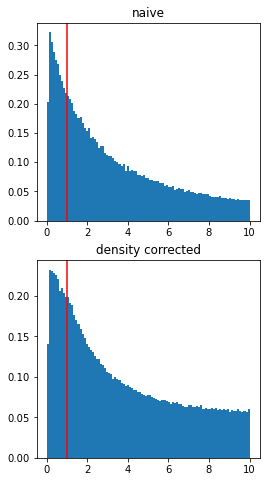

In [195]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8))

vir = sn.part0.VirialParameter
ax[0].hist(vir, bins=np.linspace(0, 10, 100), density=True);
ax[0].axvline(1, c='r')
ax[0].set(title='naive')

vircorrected = (dens_gas / (dens_gas + avg_dens)) * sn.part0.VirialParameter
ax[1].hist(vircorrected, bins=np.linspace(0, 10, 100), density=True);
ax[1].axvline(1, c='r')
ax[1].set(title='density corrected')

In [196]:
print(len(vir[vir < 1])/len(vir))
print(len(vircorrected[vircorrected < 1])/len(vircorrected))

0.09496570470919552
0.11432627462724387


(0.0, 400.0)

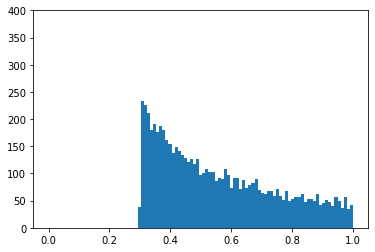

In [197]:
key = np.logical_and(dens_gas > 0.301302, vir < 1)
plt.hist(dens_gas[key], bins=np.linspace(0, 1, 100));
plt.ylim(0, 400)

Text(0.5, 0, 'log(star forming density)')

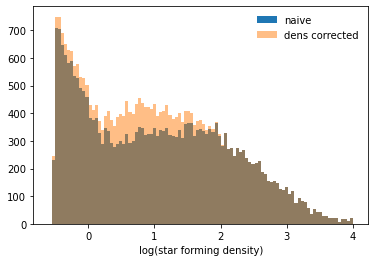

In [198]:
key = np.logical_and(dens_gas > 0.301302, vir < 1)
plt.hist(np.log10(dens_gas[key]), bins=np.linspace(-0.6, 4, 100), label='naive');

key = np.logical_and(dens_gas > 0.301302, vircorrected < 1)
plt.hist(np.log10(dens_gas[key]), bins=np.linspace(-0.6, 4, 100), alpha=0.5, label='dens corrected');
# plt.ylim(0, 600)
# plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('log(star forming density)')

In [199]:
bool0 = vir >= 1
bool1 = vircorrected < 1
bool2 = dens_gas > 0.301302
bool3 = dens_gas < 1

key_newsf = np.logical_and(np.logical_and(bool0, bool1), np.logical_and(bool2, bool3))

Text(0, 0.5, 'kpc')

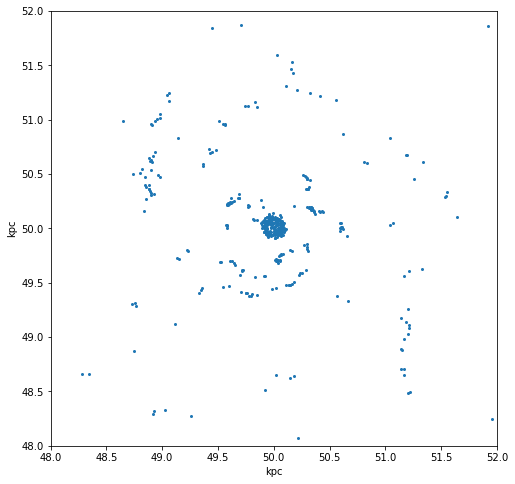

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(pos_gas[:,0][key_newsf], pos_gas[:,1][key_newsf], s=4)
plt.xlim(48, 52)
plt.ylim(48, 52)
plt.xlabel('kpc')
plt.ylabel('kpc')

0.026573811182971568
0.02686032515736672


Text(0.5, 0, 'log(star forming density)')

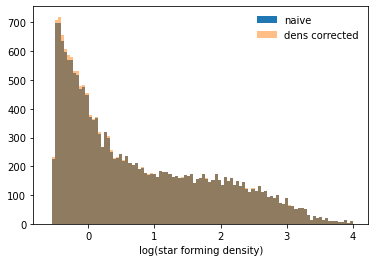

In [208]:
r = np.linalg.norm(pos_gas - np.array([50, 50, 50]), axis=1)

key = np.logical_and(dens_gas > 0.301302, vir < 1)
key = np.logical_and(key, r > 0.8)
plt.hist(np.log10(dens_gas[key]), bins=np.linspace(-0.6, 4, 100), label='naive');

print(len(np.where(key)[0])/len(key))

key = np.logical_and(dens_gas > 0.301302, vircorrected < 1)
key = np.logical_and(key, r > 0.8)
plt.hist(np.log10(dens_gas[key]), bins=np.linspace(-0.6, 4, 100), alpha=0.5, label='dens corrected');

print(len(np.where(key)[0])/len(key))

# plt.ylim(0, 600)
# plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('log(star forming density)')

### redo analysis for MW3

In [ ]:
sn = arepo.Snapshot(basepath + '/runs/MW2iso_fg0.5/lvl3/output', 20, combineFiles=True)